In [1]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def Table_variable_type_N(df_id,df,N,types,
                          title='Variable Stars',
                         x_label='Type of Variability',
                         y_label='N'):
    table = df.groupby(types).count().sort_values(by=df_id,ascending=False)[[df_id]]
    name = table.head(N).index
    value = table.head(N)[df_id].values

    # Crear el gráfico de barras utilizando Seaborn
    plt.figure(figsize=(15, 8))  # Añadir tamaño de figura
    sns.barplot(x=name, y=value)

    # Personalizar el gráfico
    plt.title(title, fontsize=20)
    plt.xlabel(x_label, fontsize=20)
    plt.ylabel(y_label, fontsize=20)

    # Aumentar el tamaño de los ticks
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Mostrar el gráfico
    plt.show()
    return table

In [9]:
gaia_splus = pd.read_csv("../../colaboracion_carlos/gaia_splus/final_result.csv",delimiter=",")

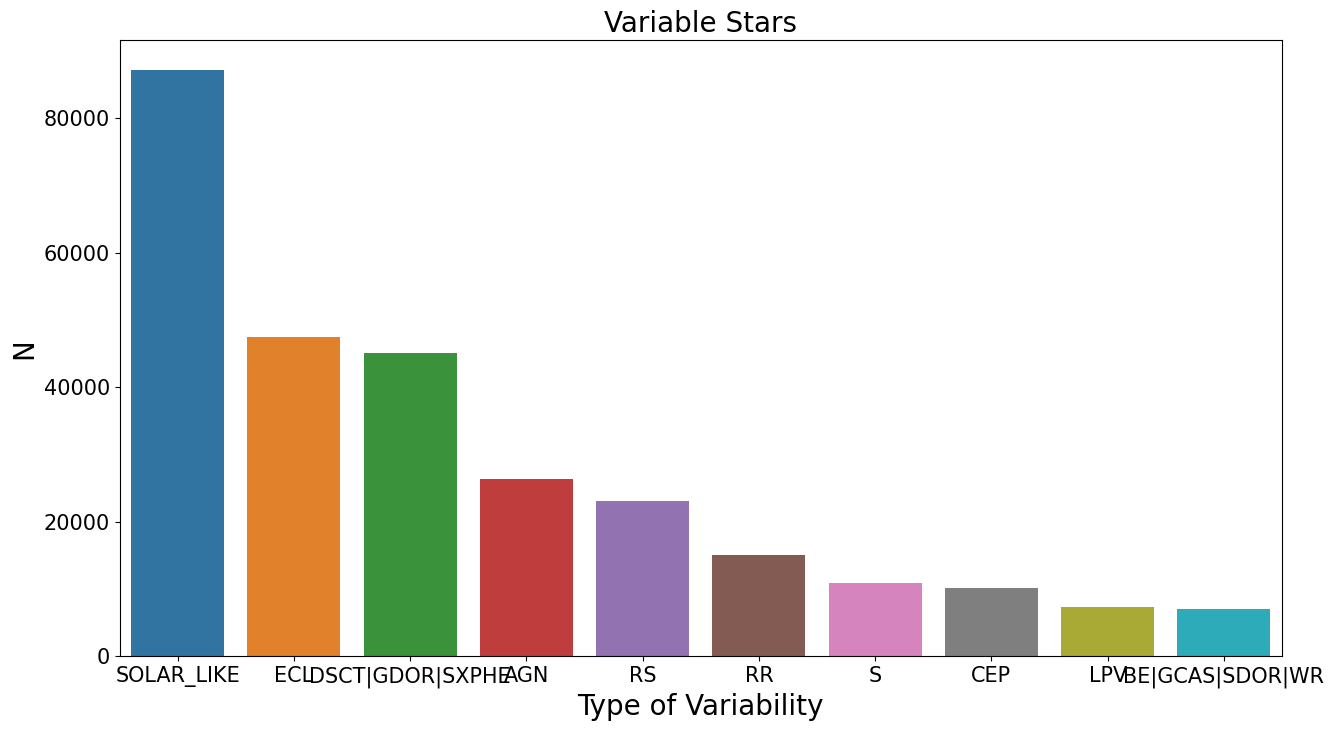

In [13]:
table = Table_variable_type_N("splus_oid_1",gaia_splus,10,"best_class_name")

In [14]:
## Random Forest

columnas_cambiar = ['mag_psf_u', 'mag_psf_J0378', 'mag_psf_J0395', 'mag_psf_J0410',
                    'mag_psf_J0430', 'mag_psf_g', 'mag_psf_J0515', 'mag_psf_r',
                    'mag_psf_J0660', 'mag_psf_i', 'mag_psf_J0861', 'mag_psf_z']

# Crear un diccionario de mapeo de nombres de columna
mapeo_nombres = {col: col.split('_')[-1] for col in columnas_cambiar}

# Cambiar el nombre de las columnas
gaia_splus = gaia_splus.rename(columns=mapeo_nombres)

mag_features = gaia_splus[mapeo_nombres.values()]
result = gaia_splus.loc[~mag_features.eq(-999).any(axis=1)]
df_rf = result[["splus_oid_1","best_class_name","best_class_score"]]
from itertools import combinations
for v in combinations(mag_features, 2):
    df_rf[f"{v[0]}-{v[1]}"] = result[v[0]] - result[v[1]]

/tmp/ipykernel_12015/363833014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rf[f"{v[0]}-{v[1]}"] = result[v[0]] - result[v[1]]
/tmp/ipykernel_12015/363833014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rf[f"{v[0]}-{v[1]}"] = result[v[0]] - result[v[1]]
/tmp/ipykernel_12015/363833014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [33]:
p = 0.9
n = 7

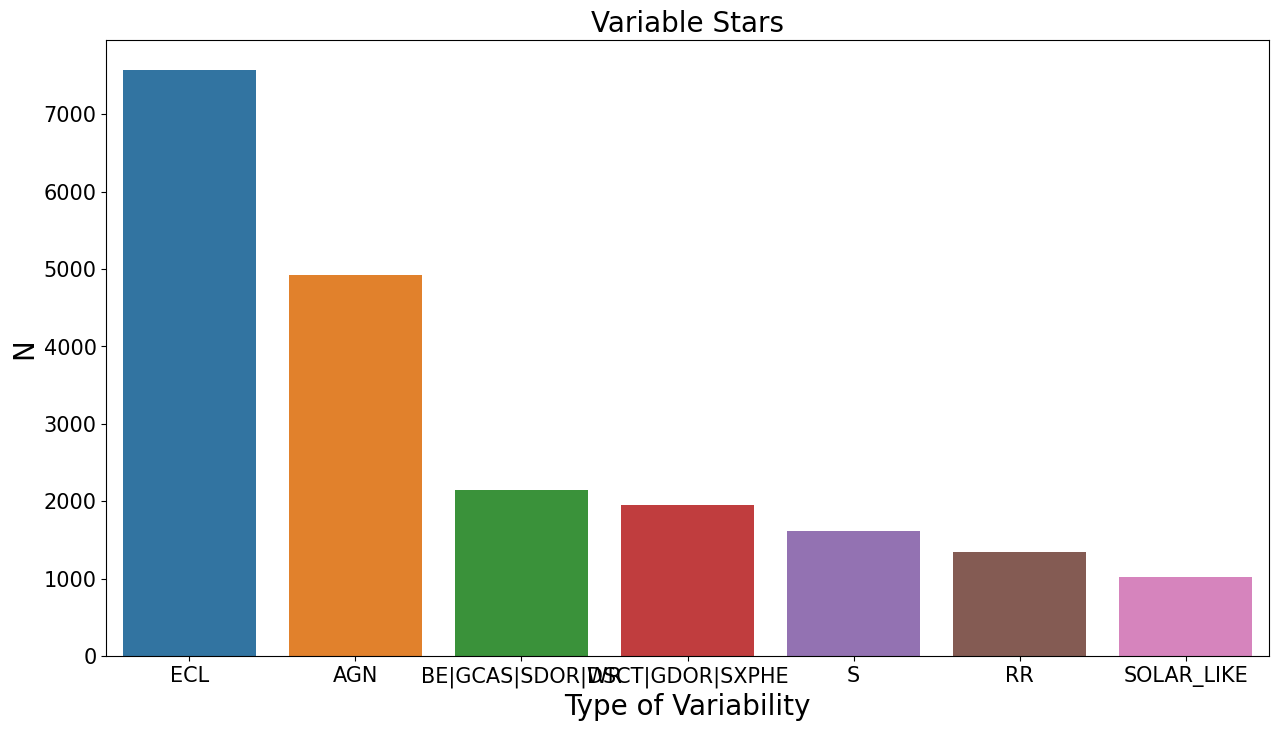

In [34]:
table = Table_variable_type_N("splus_oid_1",df_rf.loc[df_rf["best_class_score"]>p],n,"best_class_name")

In [35]:
df_rf = df_rf.loc[(df_rf["best_class_score"]>p)&
                  (df_rf["best_class_name"].isin(table.head(n).index))]

In [37]:
df_rf = df_rf.sample(1000)

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_rf['label'] = le.fit_transform(df_rf['best_class_name'])

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from imblearn.ensemble import BalancedRandomForestClassifier

X = df_rf.drop(['best_class_name',"splus_oid_1","best_class_score","label"], axis=1)
y = df_rf['label']

# Initialize a BalancedRandomForestClassifier
clf = BalancedRandomForestClassifier()

# Define hyperparameters grid
param_grid = {
    'n_estimators': [200,500,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None]
}

# Set up k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Macro-recall scorer
macro_recall = make_scorer(recall_score, average='macro')

# Grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring=macro_recall, n_jobs=-1, verbose=1)

grid_search.fit(X, y)

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (macro-recall): {:.2f}".format(grid_search.best_score_))


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this w

/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this w

/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this w

/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this w

Best parameters found:  {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
Best cross-validation score (macro-recall): 0.78


In [40]:
print("Best cross-validation score (macro-recall): {:.2f}".format(grid_search.best_score_))
print("Best parameters found: ", grid_search.best_params_)


Best cross-validation score (macro-recall): 0.78
Best parameters found:  {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}


In [41]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

# Carga tu conjunto de datos
# Asumo que ya has cargado tu DataFrame como df_rf

X = df_rf.drop(['best_class_name',"splus_oid_1","best_class_score","label"], axis=1)
y = df_rf['label']

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

iteration = 0

for train_index, test_index in sss.split(X, y):
    iteration += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ahora puedes entrenar tus modelos con estos conjuntos de entrenamiento y prueba.
    # Por ejemplo, imprimamos el número de la iteración y la distribución de las clases en el conjunto de prueba:
    print(f"Iteración {iteration}")
    print(y_test.value_counts(normalize=True))
    best_brfc = grid_search.best_estimator_
    best_brfc.fit(X_train, y_train)
    y_pred = best_brfc.predict(X_test)

    # Calculate precision, recall, and F1 score for each class
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)

    # Display results
    classes = list(set(y_test))
    for cls, precision, recall, f1 in zip(classes, precision_per_class, recall_per_class, f1_per_class):
        print(f"Class {cls}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("----------")




Iteración 1
label
3    0.375
0    0.255
1    0.090
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 1.0000
Recall: 0.9608
F1 Score: 0.9800
----------
Class 1
Precision: 0.6923
Recall: 1.0000
F1 Score: 0.8182
----------
Class 2
Precision: 0.5000
Recall: 0.7500
F1 Score: 0.6000
----------
Class 3
Precision: 0.9000
Recall: 0.4800
F1 Score: 0.6261
----------
Class 4
Precision: 0.6111
Recall: 0.7857
F1 Score: 0.6875
----------
Class 5
Precision: 0.3200
Recall: 0.5333
F1 Score: 0.4000
----------
Class 6
Precision: 0.5000
Recall: 0.8182
F1 Score: 0.6207
----------
Iteración 2
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9592
Recall: 0.9400
F1 Score: 0.9495
----------
Class 1
Precision: 0.7826
Recall: 0.9474
F1 Score: 0.8571
----------
Class 2
Precision: 0.5217
Recall: 0.7500
F1 Score: 0.6154
----------
Class 3
Precision: 0.8750
Recall: 0.4667
F1 Score: 0.6087
----------
Class 4
Precision: 0.6316
Recall: 0.8571
F1 Score: 0.7273
----------
Class 5
Precision: 0.3571
Recall: 0.6667
F1 Score: 0.4651
----------
Class 6
Precision: 0.5556
Recall: 0.9091
F1 Score: 0.6897
----------
Iteración 3
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 1.0000
Recall: 0.9800
F1 Score: 0.9899
----------
Class 1
Precision: 0.7917
Recall: 1.0000
F1 Score: 0.8837
----------
Class 2
Precision: 0.5909
Recall: 0.8125
F1 Score: 0.6842
----------
Class 3
Precision: 0.9444
Recall: 0.4533
F1 Score: 0.6126
----------
Class 4
Precision: 0.5000
Recall: 0.8571
F1 Score: 0.6316
----------
Class 5
Precision: 0.2692
Recall: 0.4667
F1 Score: 0.3415
----------
Class 6
Precision: 0.4737
Recall: 0.8182
F1 Score: 0.6000
----------
Iteración 4
label
3    0.375
0    0.255
1    0.090
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9800
Recall: 0.9608
F1 Score: 0.9703
----------
Class 1
Precision: 0.8000
Recall: 0.8889
F1 Score: 0.8421
----------
Class 2
Precision: 0.5333
Recall: 1.0000
F1 Score: 0.6957
----------
Class 3
Precision: 0.8750
Recall: 0.3733
F1 Score: 0.5234
----------
Class 4
Precision: 0.7059
Recall: 0.8571
F1 Score: 0.7742
----------
Class 5
Precision: 0.3793
Recall: 0.7333
F1 Score: 0.5000
----------
Class 6
Precision: 0.4091
Recall: 0.8182
F1 Score: 0.5455
----------
Iteración 5
label
3    0.375
0    0.255
1    0.090
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9792
Recall: 0.9216
F1 Score: 0.9495
----------
Class 1
Precision: 0.7273
Recall: 0.8889
F1 Score: 0.8000
----------
Class 2
Precision: 0.5385
Recall: 0.8750
F1 Score: 0.6667
----------
Class 3
Precision: 0.9024
Recall: 0.4933
F1 Score: 0.6379
----------
Class 4
Precision: 0.8125
Recall: 0.9286
F1 Score: 0.8667
----------
Class 5
Precision: 0.3913
Recall: 0.6000
F1 Score: 0.4737
----------
Class 6
Precision: 0.4167
Recall: 0.9091
F1 Score: 0.5714
----------
Iteración 6
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9800
Recall: 0.9800
F1 Score: 0.9800
----------
Class 1
Precision: 0.6786
Recall: 1.0000
F1 Score: 0.8085
----------
Class 2
Precision: 0.6316
Recall: 0.7500
F1 Score: 0.6857
----------
Class 3
Precision: 0.9118
Recall: 0.4133
F1 Score: 0.5688
----------
Class 4
Precision: 0.4762
Recall: 0.7143
F1 Score: 0.5714
----------
Class 5
Precision: 0.3750
Recall: 0.6000
F1 Score: 0.4615
----------
Class 6
Precision: 0.4167
Recall: 0.9091
F1 Score: 0.5714
----------
Iteración 7
label
3    0.375
0    0.255
1    0.090
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9800
Recall: 0.9608
F1 Score: 0.9703
----------
Class 1
Precision: 0.6957
Recall: 0.8889
F1 Score: 0.7805
----------
Class 2
Precision: 0.5172
Recall: 0.9375
F1 Score: 0.6667
----------
Class 3
Precision: 0.8889
Recall: 0.3200
F1 Score: 0.4706
----------
Class 4
Precision: 0.5714
Recall: 0.8571
F1 Score: 0.6857
----------
Class 5
Precision: 0.3600
Recall: 0.6000
F1 Score: 0.4500
----------
Class 6
Precision: 0.4000
Recall: 0.9091
F1 Score: 0.5556
----------
Iteración 8
label
3    0.375
0    0.255
1    0.090
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 1.0000
Recall: 0.9804
F1 Score: 0.9901
----------
Class 1
Precision: 0.6522
Recall: 0.8333
F1 Score: 0.7317
----------
Class 2
Precision: 0.5455
Recall: 0.7500
F1 Score: 0.6316
----------
Class 3
Precision: 0.8298
Recall: 0.5200
F1 Score: 0.6393
----------
Class 4
Precision: 0.6500
Recall: 0.9286
F1 Score: 0.7647
----------
Class 5
Precision: 0.4545
Recall: 0.6667
F1 Score: 0.5405
----------
Class 6
Precision: 0.5000
Recall: 0.7273
F1 Score: 0.5926
----------
Iteración 9
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9412
Recall: 0.9600
F1 Score: 0.9505
----------
Class 1
Precision: 0.7826
Recall: 0.9474
F1 Score: 0.8571
----------
Class 2
Precision: 0.5263
Recall: 0.6250
F1 Score: 0.5714
----------
Class 3
Precision: 0.8889
Recall: 0.4267
F1 Score: 0.5766
----------
Class 4
Precision: 0.4583
Recall: 0.7857
F1 Score: 0.5789
----------
Class 5
Precision: 0.4167
Recall: 0.6667
F1 Score: 0.5128
----------
Class 6
Precision: 0.4783
Recall: 1.0000
F1 Score: 0.6471
----------
Iteración 10
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 1.0000
Recall: 0.9800
F1 Score: 0.9899
----------
Class 1
Precision: 0.7037
Recall: 1.0000
F1 Score: 0.8261
----------
Class 2
Precision: 0.4828
Recall: 0.8750
F1 Score: 0.6222
----------
Class 3
Precision: 0.8056
Recall: 0.3867
F1 Score: 0.5225
----------
Class 4
Precision: 0.6154
Recall: 0.5714
F1 Score: 0.5926
----------
Class 5
Precision: 0.3929
Recall: 0.7333
F1 Score: 0.5116
----------
Class 6
Precision: 0.5556
Recall: 0.9091
F1 Score: 0.6897
----------
Iteración 11
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 1.0000
Recall: 0.9400
F1 Score: 0.9691
----------
Class 1
Precision: 0.6207
Recall: 0.9474
F1 Score: 0.7500
----------
Class 2
Precision: 0.5652
Recall: 0.8125
F1 Score: 0.6667
----------
Class 3
Precision: 0.8966
Recall: 0.3467
F1 Score: 0.5000
----------
Class 4
Precision: 0.6087
Recall: 1.0000
F1 Score: 0.7568
----------
Class 5
Precision: 0.3636
Recall: 0.5333
F1 Score: 0.4324
----------
Class 6
Precision: 0.3704
Recall: 0.9091
F1 Score: 0.5263
----------
Iteración 12
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9804
Recall: 1.0000
F1 Score: 0.9901
----------
Class 1
Precision: 0.6800
Recall: 0.8947
F1 Score: 0.7727
----------
Class 2
Precision: 0.5769
Recall: 0.9375
F1 Score: 0.7143
----------
Class 3
Precision: 0.9118
Recall: 0.4133
F1 Score: 0.5688
----------
Class 4
Precision: 0.5909
Recall: 0.9286
F1 Score: 0.7222
----------
Class 5
Precision: 0.4231
Recall: 0.7333
F1 Score: 0.5366
----------
Class 6
Precision: 0.4375
Recall: 0.6364
F1 Score: 0.5185
----------
Iteración 13
label
3    0.375
0    0.255
1    0.090
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9600
Recall: 0.9412
F1 Score: 0.9505
----------
Class 1
Precision: 0.5625
Recall: 1.0000
F1 Score: 0.7200
----------
Class 2
Precision: 0.5714
Recall: 0.7500
F1 Score: 0.6486
----------
Class 3
Precision: 0.8438
Recall: 0.3600
F1 Score: 0.5047
----------
Class 4
Precision: 0.4706
Recall: 0.5714
F1 Score: 0.5161
----------
Class 5
Precision: 0.3667
Recall: 0.7333
F1 Score: 0.4889
----------
Class 6
Precision: 0.5556
Recall: 0.9091
F1 Score: 0.6897
----------
Iteración 14
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9608
Recall: 0.9800
F1 Score: 0.9703
----------
Class 1
Precision: 0.6923
Recall: 0.9474
F1 Score: 0.8000
----------
Class 2
Precision: 0.5217
Recall: 0.7500
F1 Score: 0.6154
----------
Class 3
Precision: 0.8519
Recall: 0.3067
F1 Score: 0.4510
----------
Class 4
Precision: 0.5909
Recall: 0.9286
F1 Score: 0.7222
----------
Class 5
Precision: 0.3636
Recall: 0.8000
F1 Score: 0.5000
----------
Class 6
Precision: 0.5000
Recall: 0.8182
F1 Score: 0.6207
----------
Iteración 15
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9792
Recall: 0.9400
F1 Score: 0.9592
----------
Class 1
Precision: 0.7037
Recall: 1.0000
F1 Score: 0.8261
----------
Class 2
Precision: 0.7222
Recall: 0.8125
F1 Score: 0.7647
----------
Class 3
Precision: 0.8974
Recall: 0.4667
F1 Score: 0.6140
----------
Class 4
Precision: 0.6190
Recall: 0.9286
F1 Score: 0.7429
----------
Class 5
Precision: 0.3793
Recall: 0.7333
F1 Score: 0.5000
----------
Class 6
Precision: 0.5000
Recall: 0.8182
F1 Score: 0.6207
----------
Iteración 16
label
3    0.375
0    0.255
1    0.090
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9800
Recall: 0.9608
F1 Score: 0.9703
----------
Class 1
Precision: 0.8571
Recall: 1.0000
F1 Score: 0.9231
----------
Class 2
Precision: 0.5909
Recall: 0.8125
F1 Score: 0.6842
----------
Class 3
Precision: 0.8684
Recall: 0.4400
F1 Score: 0.5841
----------
Class 4
Precision: 0.5500
Recall: 0.7857
F1 Score: 0.6471
----------
Class 5
Precision: 0.3438
Recall: 0.7333
F1 Score: 0.4681
----------
Class 6
Precision: 0.5882
Recall: 0.9091
F1 Score: 0.7143
----------
Iteración 17
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 1.0000
Recall: 0.9800
F1 Score: 0.9899
----------
Class 1
Precision: 0.7037
Recall: 1.0000
F1 Score: 0.8261
----------
Class 2
Precision: 0.5000
Recall: 0.8125
F1 Score: 0.6190
----------
Class 3
Precision: 0.9118
Recall: 0.4133
F1 Score: 0.5688
----------
Class 4
Precision: 0.6667
Recall: 0.8571
F1 Score: 0.7500
----------
Class 5
Precision: 0.3704
Recall: 0.6667
F1 Score: 0.4762
----------
Class 6
Precision: 0.4737
Recall: 0.8182
F1 Score: 0.6000
----------
Iteración 18
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 0.9796
Recall: 0.9600
F1 Score: 0.9697
----------
Class 1
Precision: 0.7500
Recall: 0.9474
F1 Score: 0.8372
----------
Class 2
Precision: 0.7647
Recall: 0.8125
F1 Score: 0.7879
----------
Class 3
Precision: 0.8667
Recall: 0.3467
F1 Score: 0.4952
----------
Class 4
Precision: 0.4545
Recall: 0.7143
F1 Score: 0.5556
----------
Class 5
Precision: 0.3143
Recall: 0.7333
F1 Score: 0.4400
----------
Class 6
Precision: 0.3913
Recall: 0.8182
F1 Score: 0.5294
----------
Iteración 19
label
3    0.375
0    0.255
1    0.090
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 1.0000
Recall: 0.9608
F1 Score: 0.9800
----------
Class 1
Precision: 0.7619
Recall: 0.8889
F1 Score: 0.8205
----------
Class 2
Precision: 0.6087
Recall: 0.8750
F1 Score: 0.7179
----------
Class 3
Precision: 0.9070
Recall: 0.5200
F1 Score: 0.6610
----------
Class 4
Precision: 0.8000
Recall: 0.8571
F1 Score: 0.8276
----------
Class 5
Precision: 0.4138
Recall: 0.8000
F1 Score: 0.5455
----------
Class 6
Precision: 0.4000
Recall: 0.7273
F1 Score: 0.5161
----------
Iteración 20
label
3    0.375
0    0.250
1    0.095
2    0.080
5    0.075
4    0.070
6    0.055
Name: proportion, dtype: float64


/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/nico/miniconda3/envs/deep/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Class 0
Precision: 1.0000
Recall: 0.9200
F1 Score: 0.9583
----------
Class 1
Precision: 0.6071
Recall: 0.8947
F1 Score: 0.7234
----------
Class 2
Precision: 0.5909
Recall: 0.8125
F1 Score: 0.6842
----------
Class 3
Precision: 0.8286
Recall: 0.3867
F1 Score: 0.5273
----------
Class 4
Precision: 0.5000
Recall: 0.8571
F1 Score: 0.6316
----------
Class 5
Precision: 0.3871
Recall: 0.8000
F1 Score: 0.5217
----------
Class 6
Precision: 0.5000
Recall: 0.6364
F1 Score: 0.5600
----------


In [69]:
# Crear una lista de nombres de columnas:
column_names = []

for metric in ['precision', 'recall', 'f1']:
    for cls in classes:
        column_names.append(f"{cls}_{metric}")

print(column_names)


['0_precision', '1_precision', '2_precision', '3_precision', '4_precision', '5_precision', '6_precision', '0_recall', '1_recall', '2_recall', '3_recall', '4_recall', '5_recall', '6_recall', '0_f1', '1_f1', '2_f1', '3_f1', '4_f1', '5_f1', '6_f1']


In [70]:
column_names

['0_precision',
 '1_precision',
 '2_precision',
 '3_precision',
 '4_precision',
 '5_precision',
 '6_precision',
 '0_recall',
 '1_recall',
 '2_recall',
 '3_recall',
 '4_recall',
 '5_recall',
 '6_recall',
 '0_f1',
 '1_f1',
 '2_f1',
 '3_f1',
 '4_f1',
 '5_f1',
 '6_f1']

In [68]:
pd.DataFrame(np.concatenate((precision_per_class,recall_per_class,f1_per_class),axis=0)).T

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,0.607143,0.590909,0.828571,0.5,0.387097,0.5,0.92,0.894737,0.8125,...,0.857143,0.8,0.636364,0.958333,0.723404,0.684211,0.527273,0.631579,0.521739,0.56


In [42]:
precision_per_class

array([1.        , 0.60714286, 0.59090909, 0.82857143, 0.5       ,
       0.38709677, 0.5       ])

In [43]:
recall_per_class

array([0.92      , 0.89473684, 0.8125    , 0.38666667, 0.85714286,
       0.8       , 0.63636364])

In [97]:
sss.split(X, y)

<generator object BaseShuffleSplit.split at 0x7fb749611eb0>

In [88]:
y_pred = best_brfc.predict(X_test)


In [25]:
from sklearn.metrics import classification_report


In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1620
           1       0.79      0.95      0.86       621
           2       0.72      0.91      0.80      1035
           3       0.89      0.54      0.67      2525
           4       0.78      0.88      0.83       593
           5       0.40      0.71      0.51       553
           6       0.78      0.87      0.82       797

    accuracy                           0.79      7744
   macro avg       0.76      0.83      0.78      7744
weighted avg       0.82      0.79      0.79      7744



In [89]:
y_pred

array([0, 0, 5, ..., 4, 1, 0])

In [90]:
y_test

181360    6
268047    3
243245    4
186644    5
9536      4
         ..
160239    0
232710    3
171413    0
275425    3
40088     3
Name: label, Length: 7903, dtype: int64